In [11]:
# TODO Elaborate on theoretical background of asymmetric gradient

# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [7]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import copy
import glob
import random

%matplotlib inline

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


# 1. The Dataset

#### Choose to use google colab or run locally

In [9]:
COLAB = True

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r"/content/drive/My Drive/data/"
    N_SAMPLES = 100
else:
    DATA_PATH = r"./images/"
    N_SAMPLES = 10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load sample of healthy and diseased plants

In [10]:
random.seed(7)
torch.manual_seed(7)

# don't use DataLoader and ImageFolder here, since we only need the N_SAMPLES per class
filelist = [
    *random.sample(glob.glob(DATA_PATH + "/Apple___healthy/*.JPG"), N_SAMPLES),
    *random.sample(glob.glob(DATA_PATH + "/Apple___Black_rot/*.JPG"), N_SAMPLES),
]

# load all images in filelist into tensor
X = torch.stack([transforms.ToTensor()(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)) for fname in filelist])
# X = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X) # normalize on vgg16 data
y = torch.tensor([0] * N_SAMPLES + [1] * N_SAMPLES)

#### Plot some example images for both classes

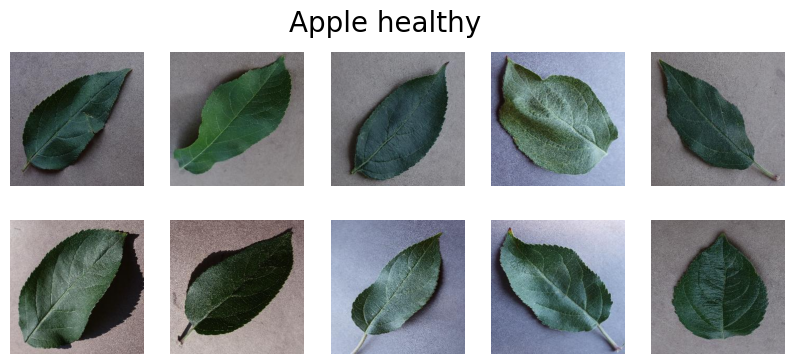

<Figure size 640x480 with 0 Axes>

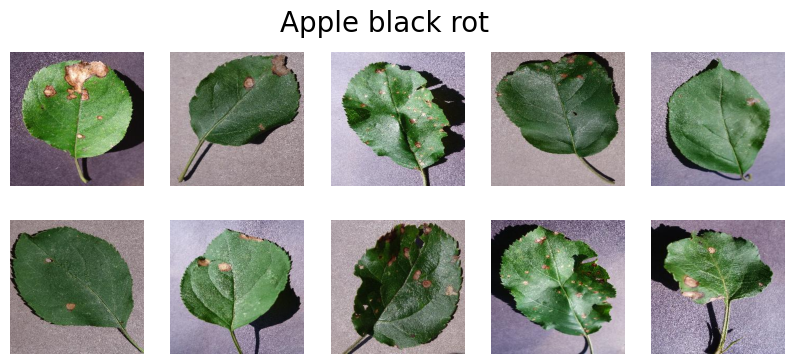

<Figure size 640x480 with 0 Axes>

In [16]:
# plot some images in a grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()
    plt.tight_layout()

plot_images(X[y == 0], "Apple healthy")
plot_images(X[y == 1], "Apple black rot")

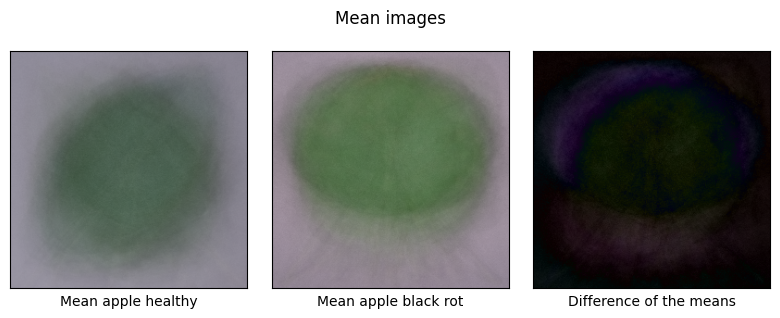

In [17]:
# Visualise mean images
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
mean0 = torch.mean(X[y == 0].permute(0, 2, 3, 1), dim=0)
mean1 = torch.mean(X[y == 1].permute(0, 2, 3, 1), dim=0)
diff = mean0 - mean1
diff = torch.abs(diff)

axs[0].imshow(mean0)
axs[1].imshow(mean1)
axs[2].imshow(diff)

axs[0].set(xlabel="Mean apple healthy", xticks=[], yticks=[])
axs[1].set(xlabel="Mean apple black rot", xticks=[], yticks=[])
axs[2].set(xlabel="Difference of the means", xticks=[], yticks=[])
plt.suptitle("Mean images")
plt.tight_layout()

#### Observation:
The mean shape and colour of the leaves appears to differ in the two conditions.

The pixel-wise absolute mean difference of the images (healthy control subtrackted from diseased leaves mean image) is most pronounced outside of the mean healthy leave shape and somewhat pronounced within the mean healthy leave shape.

# 2. Pretrained Models for Image Recognition

#### Use features of vgg16 model

In [11]:
model_features = nn.Sequential(
    *vgg16(weights=VGG16_Weights.DEFAULT).features,
    torch.nn.Flatten(start_dim=1)
)

model_features.to(device) # model = pointer, for tensors: copy on other device
model_features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# 3. Predicting Classes from Images

#### Split data into train and test, then run through model to get feature representation.

In [12]:
X = X.to(device)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
with torch.no_grad():
    X_train_features = model_features(X_train).to("cpu")
    X_test_features = model_features(X_test).to("cpu")
    torch.cuda.empty_cache()

print(X_train_features.shape)


torch.Size([160, 32768])


#### Calculate mean feature representation per class to get ‘difference-of-means’ discriminant.

In [13]:
images_0_train = X_train_features[y_train == 0]
images_1_train = X_train_features[y_train == 1]
mean_0 = images_0_train.mean(dim=0)
mean_1 = images_1_train.mean(dim=0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()

print("Size of difference-of-means discriminant:", w.size())

# For standardizing purposes
X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)

Size of difference-of-means discriminant: torch.Size([32768])


#### Project data on the ‘difference-of-means’ discriminant using the dot product to score (new) instances.

In [21]:
pred_scores_train = torch.matmul(X_train_features, w)
pred_scores_test = torch.matmul(X_test_features, w)

#### Evaluate performance of ‘difference-of-means’ discriminant on the test set

AUC Score on the training set: 0.99875, number of instances of each class = 80.
AUC Score on the test set: 0.9925, number of instances of each class = 20.



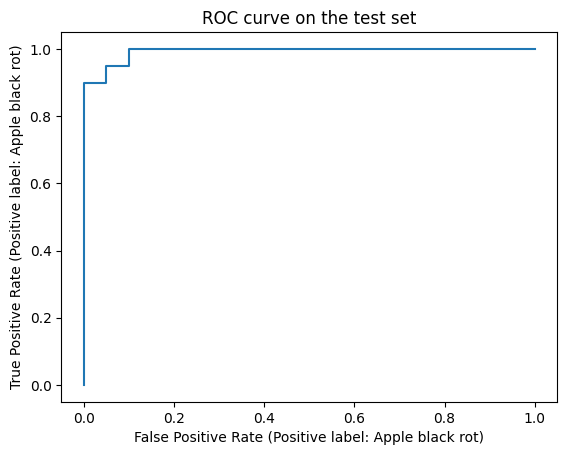

In [22]:
print(f"AUC Score on the training set: {roc_auc_score(y_train, pred_scores_train)}, number of instances of each class = {torch.sum(y_train==0).cpu()}.")
print(f"AUC Score on the test set: {roc_auc_score(y_test, pred_scores_test)}, number of instances of each class = {torch.sum(y_test==0).cpu()}.\n")

# plot a roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_scores_test, drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (Positive label: Apple black rot)")
plt.ylabel("True Positive Rate (Positive label: Apple black rot)")
plt.title("ROC curve (test set)")
plt.show()

#### Observation:
We evauated the discriminating ability of the "difference-of-means" for the two classes by plotting the Receiver Operating Characteristics (ROC) curve and computing the area under the curve (AUC) on the test set.

We made sure that our test set is balanced in regards to the number of instances from each class (20), since we split the data in a stratified fashion.

This resulted in an AUC score of 0.9925. As an aggregate measure of performance across all possible classification thresholds, it indicates a very good sepparability between classes.

# 4. Understanding the Image-Class Relation Pixel-Wise

# 4.1 Sensitivity Analysis

#### Add linear layer representing the projection on the mean difference vector.

In [23]:
projection_layer = torch.nn.Linear(in_features=X_train_features.size()[1], out_features=1, bias=False)

# use w as the weights for the projection layer
projection_layer.weight = torch.nn.Parameter(w.to(device))

# add the projection layer to the model to get the different of means model
model_dom = model_features.append(projection_layer)

#### Pixel-wise explaination for a given image:
- look at derivative of model w.r.t. input pixel
- compute importance scores by computing (square) norm of gradient per pixel (over channels)
- render scores as heatmap

#### Apply Sensitivity Analysis on image

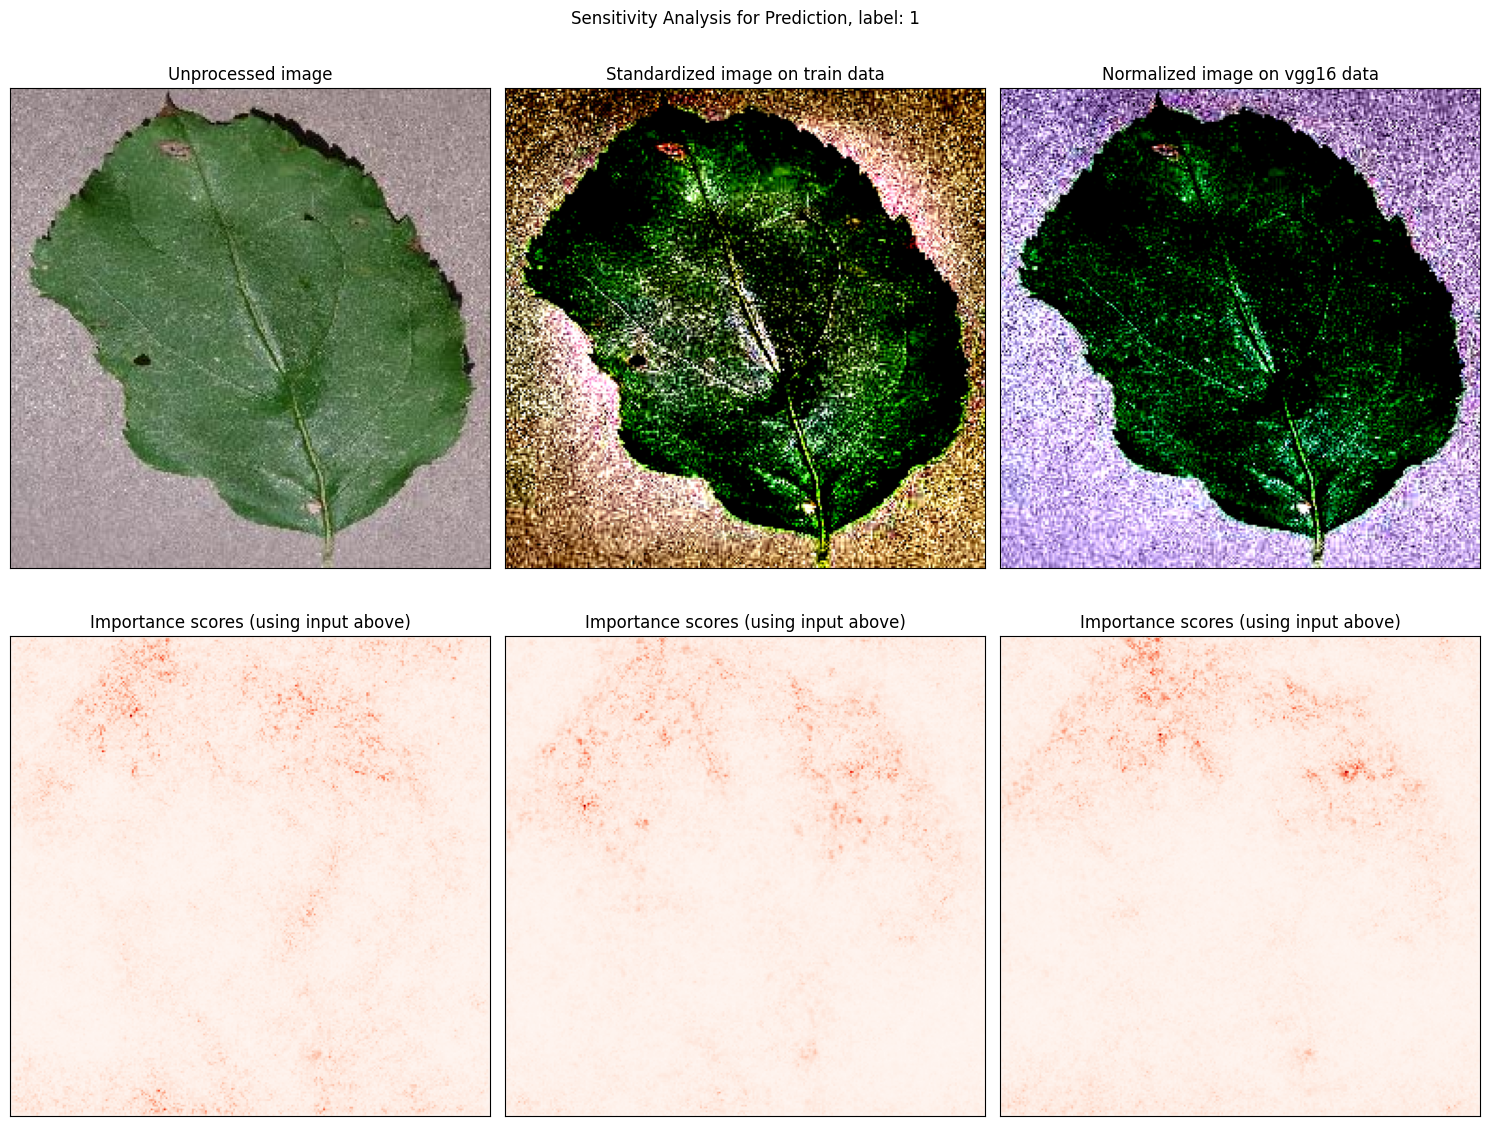

In [24]:
def get_sensitivity(model, input_data):
    output = model(input_data)
    output.backward()
    sensitivity = input_data.grad.norm(dim=1).to("cpu")  # TODO square norm?
    return sensitivity


def plot_sensitivity_analysis(test_set_id=25, model=model_dom):

    img = X_test[test_set_id].unsqueeze(0)  # on device

    input_data_standardized = (img - X_train_mean) / X_train_std

    # mean and std per channel from vgg16 training set
    input_data_standardized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)

    img.requires_grad = True
    input_data_standardized.requires_grad = True
    input_data_standardized_vgg16.requires_grad = True

    # get sensitivity
    sensitivity = get_sensitivity(model, img)
    sensitivity_norm = get_sensitivity(model, input_data_standardized)
    sensitivity_norm_vgg16 = get_sensitivity(model, input_data_standardized_vgg16)

    # plot to images
    fig, axs = plt.subplots(2, 3, figsize=(15, 12))

    axs[0, 0].imshow(torch.permute(img[0].detach().cpu(), (1, 2, 0)))
    axs[0, 1].imshow(torch.permute(input_data_standardized[0].detach().cpu(), (1, 2, 0)))
    axs[0, 2].imshow(torch.permute(input_data_standardized_vgg16[0].detach().cpu(), (1, 2, 0)))
    axs[1, 0].imshow(sensitivity.squeeze(0), cmap="Reds")
    axs[1, 1].imshow(sensitivity_norm.squeeze(0), cmap="Reds")
    axs[1, 2].imshow(sensitivity_norm_vgg16.squeeze(0), cmap="Reds")

    axs[0, 0].set_title("Unprocessed image")
    axs[0, 1].set_title("Normalized image on train data")
    axs[0, 2].set_title("Normalized image on VGG-16 data")
    axs[1, 0].set_title("Importance scores (using input above)")
    axs[1, 1].set_title("Importance scores (using input above)")
    axs[1, 2].set_title("Importance scores (using input above)")

    fig.suptitle(f"Sensitivity Analysis for Prediction, label: {y_test[test_set_id]}")
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()


plot_sensitivity_analysis(test_set_id=25, model=model_dom)

In [25]:
# TODO maybe choose a different image?

#### Observation:
We can see that rather the pixels in the upper area of the leave induce higher importance scores. However, the resulting sensitivity heatmaps are rahter noisy. The per-color-channel normalsiation of the input images seems to slightly reduce the noise, so does the normalisation based on the ImageNet data statistics. In the latter case, the contrast on the pixel importance scores is slightly increased.

We expected the normalisation of the input to provide more stable and more uniform gradients, especially if we normalise based on the data set statistics. The good results using the ImageNet data statistics imply that the image domain, used to train the VGG-16 network, is similar to our data domain and can also successfully be used for normalisation.

Batch normalisation layers in the model would potentially induce a similar affect of increasing the stability of the gradients and therby somewhat reducing the noise.


# 4.2 More Robust Explanations

#### Create biased convolution layer

In [26]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.clip(self.og_conv.weight, min=0)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.clip(self.og_conv.bias, min=0)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

####Ttest biased layer with a tensor

In [27]:
# create Conv2d layer
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
biased_conv = BiasedLayer(conv)

# Create Artificial Input
test_input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity for both versions
conv_output = conv(test_input_data)
conv_output.backward()
conv_sensitivity = test_input_data.grad.norm(dim=1)

test_conv_output = conv(test_input_data)
test_conv_output.backward()
test_conv_sensitivity = test_input_data.grad.norm(dim=1)

# Compare
print(f"Test conv output: {conv_output},\nTransformed conv output: {test_conv_output[0]}")
print("\nTest conv Sensitivity:\n", conv_sensitivity)
print("Transformed conv output:\n", test_conv_sensitivity)

Test conv output: tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>),
Transformed conv output: tensor([[[10.]]], grad_fn=<SelectBackward0>)

Test conv Sensitivity:
 tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
Transformed conv output:
 tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])


#### Copy previous VGG-16 difference-of-means model but replace Conv2d with the biased layer

In [28]:
# last linear layer is not considered by default
model_dom_biased = nn.Sequential(*[BiasedLayer(l) if isinstance(l, torch.nn.Conv2d) and i > 0 else l for i,l in enumerate(model_dom.children())])
model_dom_biased.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (biased_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (biased_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (biased_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (biased_conv): Conv2d(128, 256, kernel_size=(3,

#### Apply Sensitivity Analysis on image like before but use the biased model

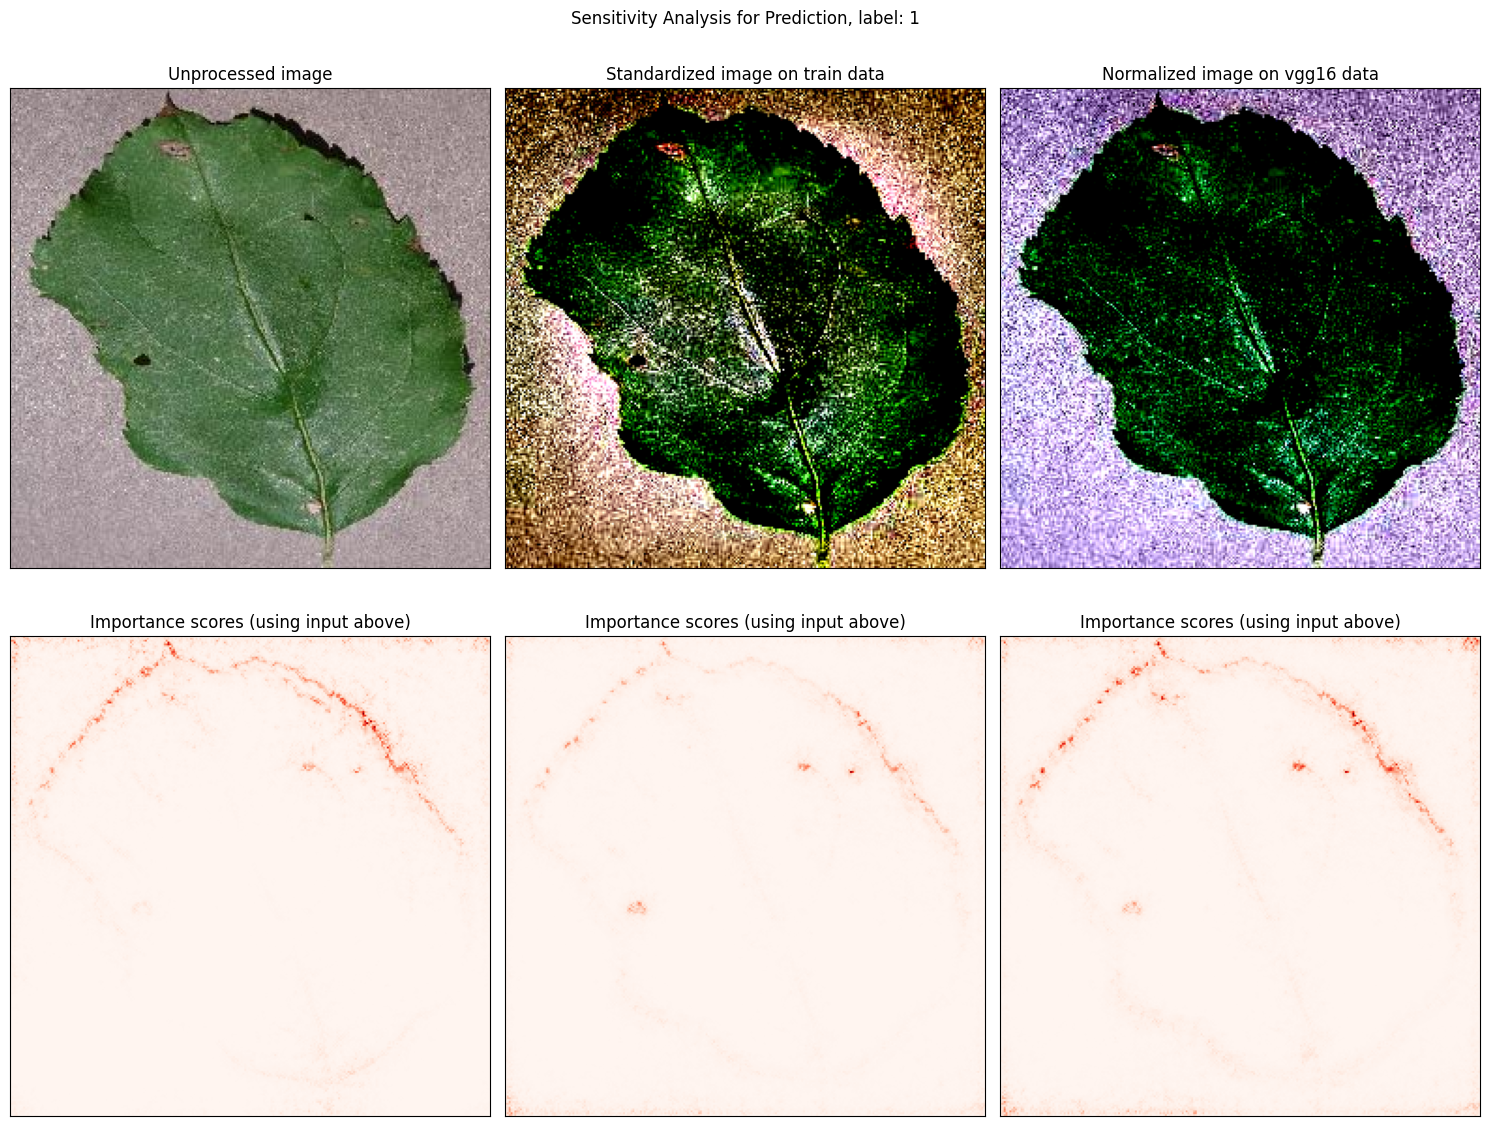

In [29]:
plot_sensitivity_analysis(test_set_id=25, model=model_dom_biased)

#### Observation:
Biasing the gradient in a way that prioritizes excitatory rather than inhibitory effects in the network has resulted in less noisy explanations.

The most important pixels have gottten higher importance scores highlighting the upper rim of the leave as well as a few spots of black rot. This is especially the case for the normalised image, since the gradients in this tend to be more uniform.

The less important pixels, on the one hand, lost their visibility in the heatmap because of the increased contrast.

In terms of interpretability, the rim of the leaf does not appear of high importance for differentiating between the groups for a human observer, but putting importance on the spots of the black rot seem to be on point.

#### Apply Sensitivity Analysis on several images and compare the different models and different input preprocessing

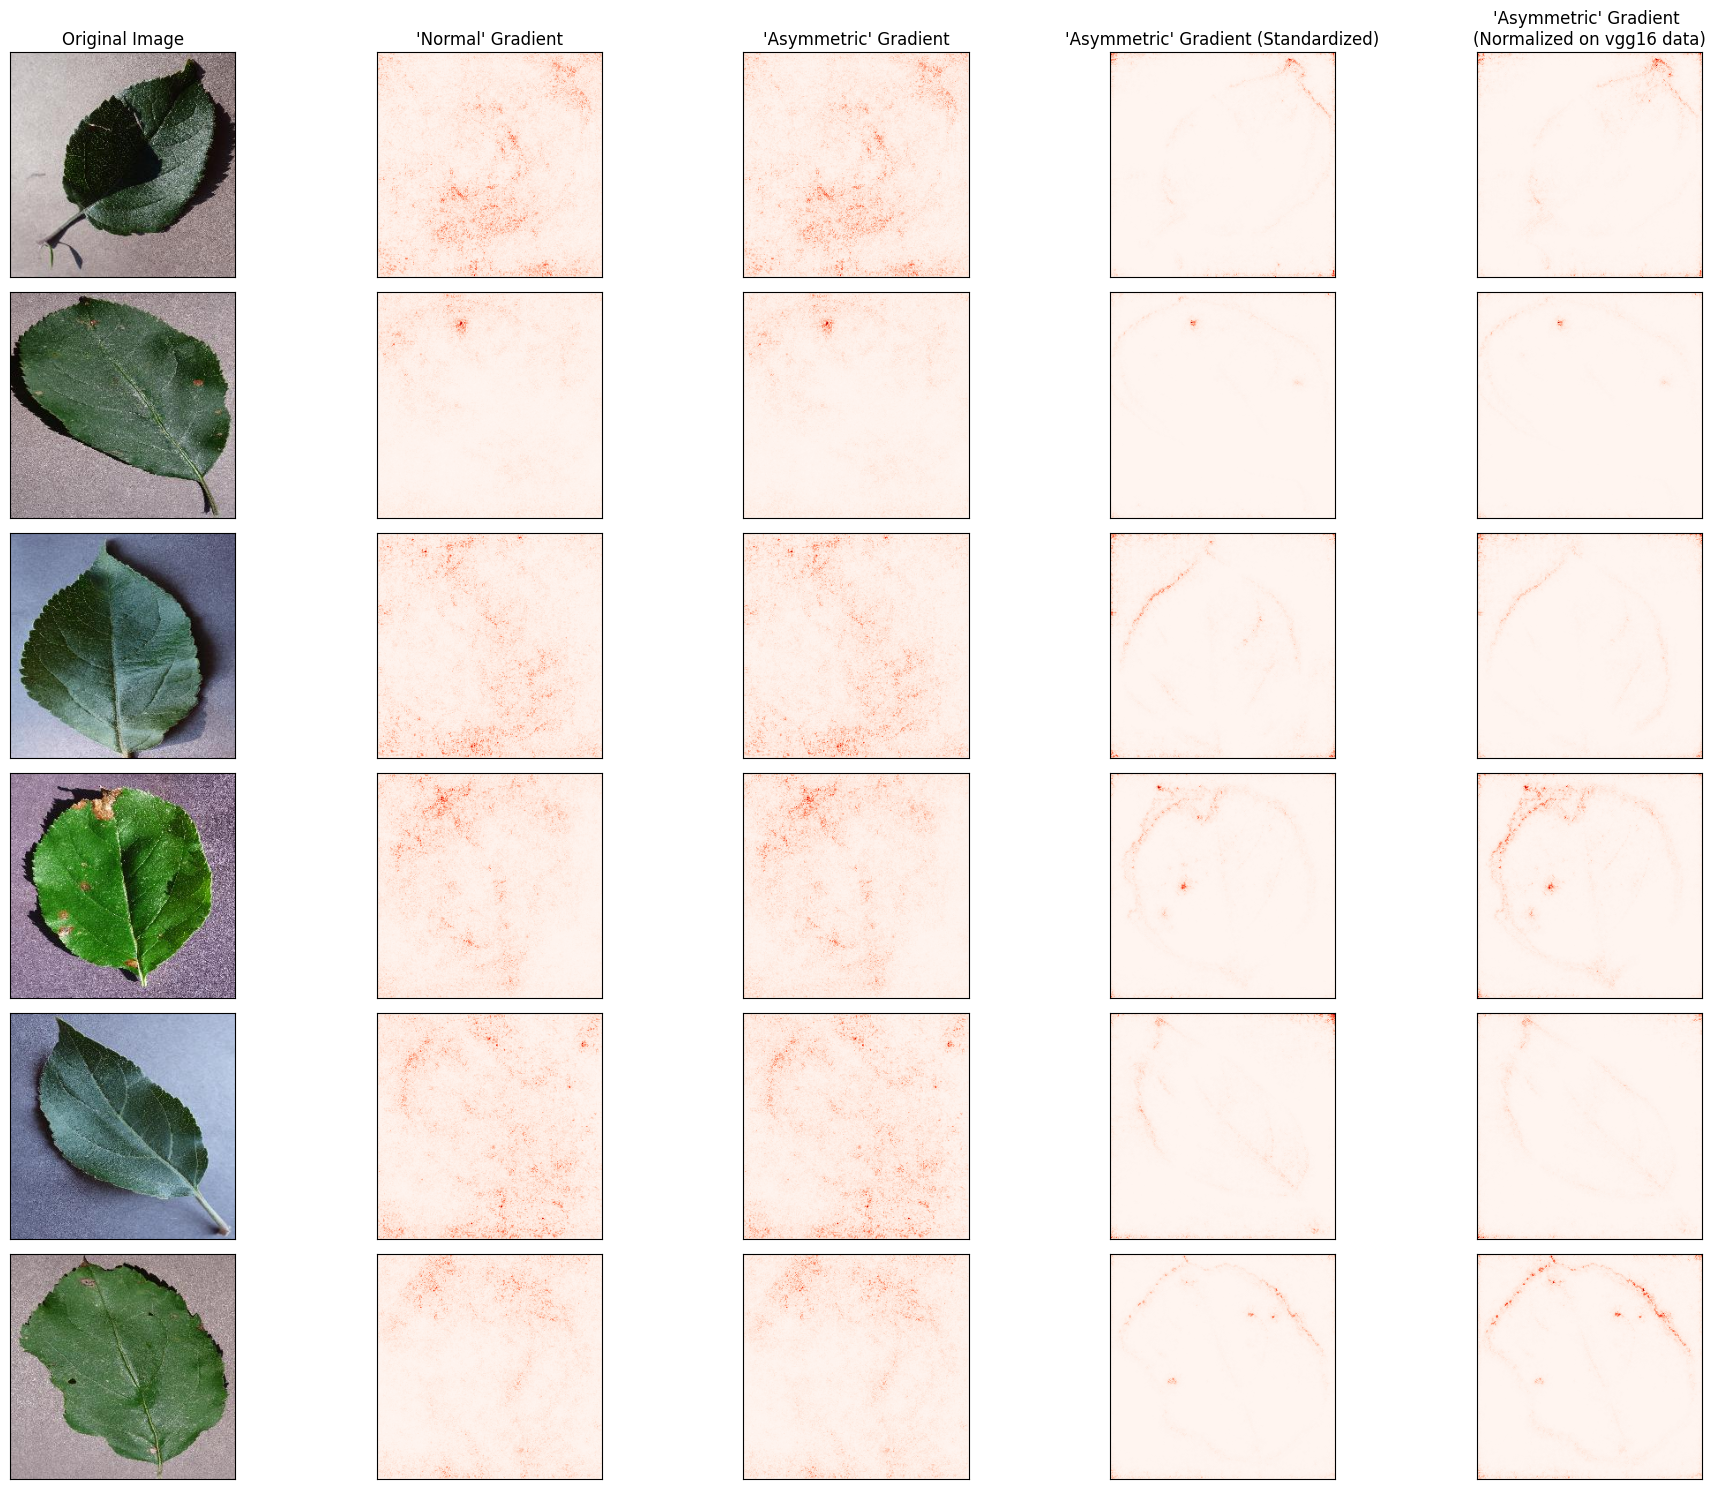

In [31]:
# compare different models
def plot_sensitivity_imgs(images):
    """ images - of shape [b, C, H, W] and stored on device """

    fig, axs = plt.subplots(len(images), 5, figsize=(20, 15))

    for i, img in enumerate(images):

        # Create standardized input
        img = img.detach() # make sure that input is leaf
        input_data_standardized = (img - X_train_mean) / X_train_std
        input_data_standardized = input_data_standardized.unsqueeze(0)
        input_data_standardized.requires_grad = True

        # create normalized input using vgg16 data
        input_data_normalized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img).unsqueeze(0)
        input_data_normalized_vgg16.requires_grad = True

        # Regular input
        input_data = img.unsqueeze(0)
        input_data.requires_grad = True

        # get sensitivity
        sensitivity_diff = get_sensitivity(model_dom, input_data)
        sensitivity_biased = get_sensitivity(model_dom_biased, input_data)
        sensitivity_biased_norm = get_sensitivity(model_dom_biased, input_data_standardized)
        sensitivitiy_biased_norm_vgg = get_sensitivity(model_dom_biased, input_data_normalized_vgg16)
        # prepare input_data for plotting
        input_data = input_data.detach().cpu().squeeze(0)

        if len(images) > 1:
          axs[i, 0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[i, 1].imshow(sensitivity_diff.squeeze(0), cmap="Reds")
          axs[i, 2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[i, 3].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[i, 4].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")
        else:
          axs[0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[1].imshow(sensitivity_diff.squeeze(0), cmap="Reds")
          axs[2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[3].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[4].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")

        if (i == 0) & (len(images) > 1):
            axs[i, 0].set_title(f"Original Image")
            axs[i, 1].set_title(f"'Normal' Gradient")
            axs[i, 2].set_title(f"'Asymmetric' Gradient")
            axs[i, 3].set_title(f"'Asymmetric' Gradient (Normalized)")
            axs[i, 4].set_title(f"'Asymmetric' Gradient \n(Normalized on VGG-16 data)")
        elif (i == 0):
            axs[0].set_title(f"Original Image")
            axs[1].set_title(f"'Normal' Gradient")
            axs[2].set_title(f"'Asymmetric' Gradient")
            axs[3].set_title(f"'Asymmetric' Gradient (Normalized)")
            axs[4].set_title(f"'Asymmetric' Gradient \n(Normalized on VGG-16 data)")

        #fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()


plot_sensitivity_imgs(X_test[[0, 11, 14, 16, 17, 25]])

In [32]:
# TODO maybe choose more suitable images?

#### Observation:
Similar tendencies can be observed for the other images in the test set.
The vanilla sensitivity heatmaps are highly noisy, the sensitivity heatmaps for asymmetric gradients produce slightly more interpretable results, while normalising the input is necessary to discard the rest of the noise.

In some cases we see the black rot dots highlighted which is a rather satisfying result. But often the (upper) contour of the leaf gets high scores.

#### Apply sensitivity analysis on the example from the project description

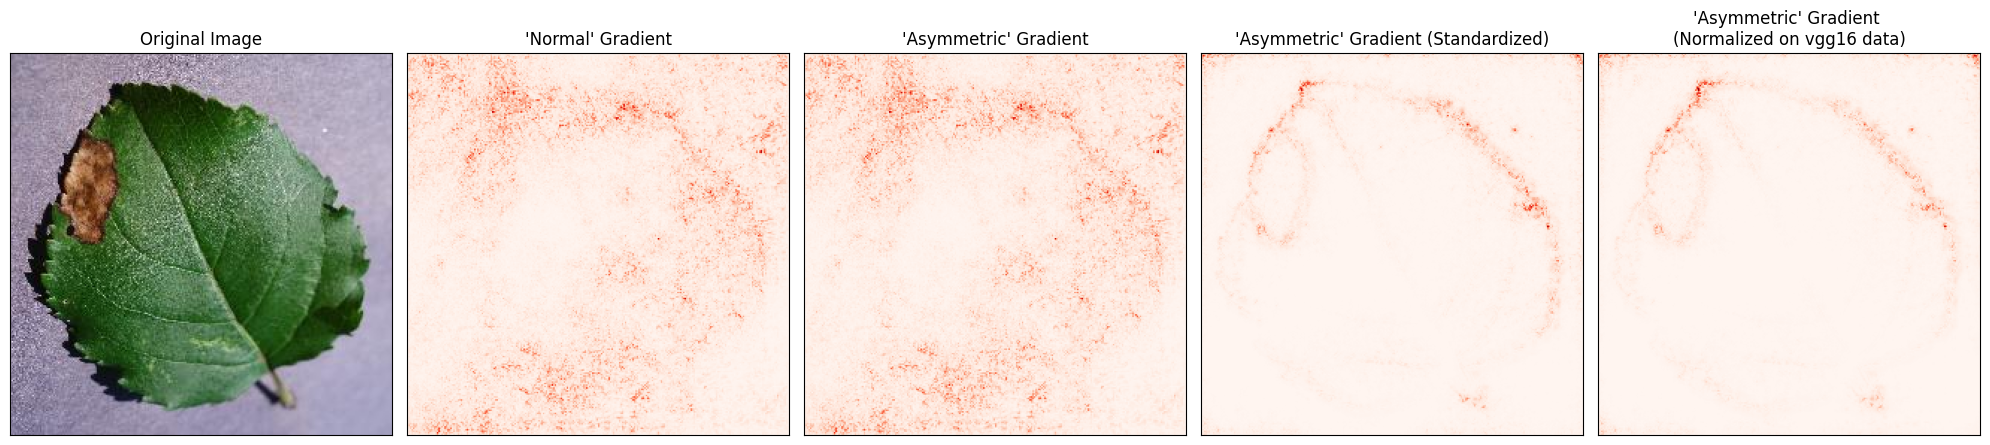

In [33]:
example_path = DATA_PATH + "/Apple___Black_rot/image (50).JPG"
example = transforms.ToTensor()(cv2.cvtColor(cv2.imread(example_path), cv2.COLOR_BGR2RGB)).to(device)
example.requires_grad = True
plot_sensitivity_imgs(example.unsqueeze(0))

# 4.3 Discussion
Possible sources of the mismatch:


## Insufficiently good pretrained neural network:
- the pretext training might be not trained well enough to derive generalizable features, maybe not even for the pretext task itself
### Possible solutions:
- check model performance of the pretrained model on an upstream task
- try to fine-tune model on our task at hand
- check if other downstream tasks exist which are suitable for this approach (derive evidence for the validity of the approach)
- experiment with other pretrained neural network models such as ResNet, AlexNet, etc.

## Improper method for extracting relevant features:
- each layer of the pretext task probably captures different aspects/features of the image
- taking the last layer may be an inacurate choice for the downstream task at hand, i.e. detecting the apple tree disease
- we can see that the contours are captured in our sensitivity analysis, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also detected sometimes)
- the data domain might be too different from ours (i.e. cars and animals instead of tree leaves)
### Possible solutions:
- try cutting of more layers to extract features
- try to fine-tune on the dataset at hand

## Problems with data quality
- the resoultion is might be low for this task, not allowing the model to capture the detailed structures or vague features
- shadows might disturb the features or introduce unwanted noise hardening the detection of structures related to the disease
- we observed the rim of the leaves to be of highest value in the pixel-wise mean difference between the classes which might point to a bias in the data sampling that gets captured in the feature extraction
### Possible solutions:
- increase the resolution of the images with designated machine learning models
- try to remove shadows either manually or with other machine learning models
- manually subsample images with less shadows
- try to get images with higher resolution and/or without shadows in the picture to reduce noise
- use image augmentation, i.e. rotation, in order to combat the sample bias
- increase the data set size in order to combat the sample bias

## Flawed understanding by the human of the plant disease
- disease might effect subtle areas of the plant which are either hard to detect for a human or even unkown to humans due to its hard decetability
### Possible solutions:
- get in touch with people with domain knowledge
- investigate if there might be subtle structural changes due to the disease unknown to the domain-experts



In [34]:
## TODO add The shortcomings of the method